In [1]:
# Importing Required Libraries

from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# helper function to find midpoint between two points
def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

In [3]:
# function to find dimensions from a 2D image
def process_image(imagepath, width):
    
    #read image using opencv
    image = cv2.imread(imagepath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (7, 7), 0)
    
    # Edge Detection using Canny() of opencv
    edged = cv2.Canny(gray, 10, 100)
    edged = cv2.dilate(edged, None, iterations=3)
    edged = cv2.erode(edged, None, iterations=1)
    
    # finding all contours from the image
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    
    #sorting contours from left to right
    (cnts, _) = contours.sort_contours(cnts)
    
    pixelsPerMetric = None           # metric for measuring objects
    resA = 0                         # area of resultant object
    
    # looping over the contours
    for c in cnts:
        
        #ignoring small contours, coz they can be noise 
        if cv2.contourArea(c) < 1000:
            continue
            
        # compute the rotated bounding box of the contour
        box = cv2.minAreaRect(c)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")
    
        # order the points in the contour such that they appear in top-left, top-right, bottom-right, and bottom-left order
        box = perspective.order_points(box)
        
        # finding midpoints on all four sides of the rectangle
        (tl, tr, br, bl) = box
        (tltrX, tltrY) = midpoint(tl, tr)
        (blbrX, blbrY) = midpoint(bl, br)
        (tlblX, tlblY) = midpoint(tl, bl)
        (trbrX, trbrY) = midpoint(tr, br)
    
        # compute the Euclidean distance between the midpoints
        dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
        dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
    
        # initialising metric with ref object's width
        if pixelsPerMetric is None:
            pixelsPerMetric = dB / width
        
        # compute the size of the object
        dimA = dA / pixelsPerMetric
        dimB = dB / pixelsPerMetric
        
        # finding the largest object in the image
        # assuming luggage is biggest in the image
        if (dimA*dimB > resA):
            resA = dimA*dimB
            resDim = (dimA,dimB)
    return resDim

In [4]:
#main function to get all  dimensions of any object

def find_dimensions(image1, image2, width1, width2):
    
    # declaring resultant variables
    res1, res2, res3 = 0, 0, 0
    
    # getting dimensions from each image
    dim1, dim2 = process_image(image1, width1)
    dim3, dim4 = process_image(image2, width2)
    
    # rounding dimensions till second decimal place
    dim1, dim2, dim3, dim4 = round(dim1,2), round(dim2,2), round(dim3,2), round(dim4,2)
    
    # finding overlapping dimension and eliminating it
    # threshold 0.25cm (can be changed)
    if(abs(dim1-dim3) > 0.25):
        res1 = dim1; res2=dim2; res3=dim3
    else:
        res1 = dim1; res2=dim2; res3=dim4
        
    return (res1,res2,res3)

In [5]:
find_dimensions('speaker1.jpeg', 'speaker2.jpeg', 7.2, 7.2)

(18.88, 6.52, 6.14)

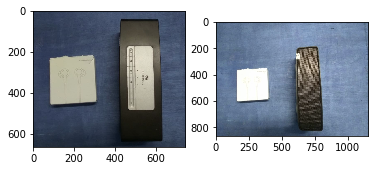

In [10]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(cv2.imread('speaker1.jpeg'))
axarr[1].imshow(cv2.imread('speaker2.jpeg'))